<a href="https://colab.research.google.com/github/kangelaa/honors-thesis/blob/main/HThesis_SVMModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Honors Thesis: Classifying Consciousness
by Angela Kan


In [1]:
#required imports
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, backend
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as spio
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm 
from statistics import mean, variance
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

#print full array setting
np.set_printoptions(threshold=1000) #revert back to regular w/ threshold=1000

## Data Imports, Preprocessing, Splitting


In [2]:
#access STSP .mat files from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


PREPROCESSING FOR NEW DATA (same lengths):

In [3]:
#SAME LENGTH VERSION - PROPOFOL DATA
#import files and save in dataframe, adding labels 

NUM_SUBJECTS=18
NUM_SCANS=38
LARGEST_X_DIM=55
LARGEST_Y_DIM=100

#array initialized w/ 0s for image data 
all_data=np.zeros((NUM_SCANS,LARGEST_X_DIM*LARGEST_Y_DIM))
#array initialized w/ 2s for label data (0 for wake, 1 for sleep)
all_labels=np.ones((NUM_SCANS))*3 #initialize with 3's

#iterate through each STSP
for i in range(1,1+NUM_SCANS):
  if i < 10:
    mat=spio.loadmat(f"/content/gdrive/MyDrive/2022-23/Honors Thesis/propofol_stsps/_fft_stsp_sub_00{i}.mat")
  else:
    mat=spio.loadmat(f"/content/gdrive/MyDrive/2022-23/Honors Thesis/propofol_stsps/_fft_stsp_sub_0{i}.mat")
  stsp = mat["stsp"]
  #cropped = stsp[:,:100]  #crop accordingly
  flat = stsp.flatten() #remove structure for SVM input
  all_data[i-1]=flat

  # #create labels dataframe
  # if i % 2 == 0: # even=wakefulness state, add label [0]
  #   all_labels[i-1]=0
  # else: # odd=sleep state, add label [1] 
  #   all_labels[i-1]=1


#reshape to be 4dim from 3dim
#all_data=np.reshape(all_data,(NUM_SUBJECTS*2,LARGEST_X_DIM,LARGEST_Y_DIM,1))

In [4]:
#SAME LENGTH VERSION - HUDETZ DATA
#import files and save in dataframe, adding labels 

NUM_SCANS=43
LARGEST_X_DIM=55
LARGEST_Y_DIM=100

#array initialized w/ 0s for image data 
all_test_data=np.zeros((NUM_SCANS,LARGEST_X_DIM*LARGEST_Y_DIM))
#array initialized w/ 2s for label data (0 for wake, 1 for sleep)
all_test_labels=np.ones((NUM_SCANS))*3 #initialize with 3's

#iterate through each STSP
for i in range(1,1+NUM_SCANS):
  if i < 10:
    mat=spio.loadmat(f"/content/gdrive/MyDrive/2022-23/Honors Thesis/hudetz_stsps/_fft_stsp_sub_00{i}.mat")
  else:
    mat=spio.loadmat(f"/content/gdrive/MyDrive/2022-23/Honors Thesis/hudetz_stsps/_fft_stsp_sub_0{i}.mat")
  stsp = mat["stsp"]
  #cropped = stsp[:,:100]  #crop accordingly
  flat = stsp.flatten() #remove structure for SVM input
  all_test_data[i-1]=flat

In [6]:
#set PROPOFOL labels based on info
info=spio.loadmat(f"/content/gdrive/MyDrive/2022-23/Honors Thesis/propofol_stsps/_fft_info.mat")
recovery = []
for i, name in enumerate(info["fft4info"]["images"][0][0]):
  if 'W1' in str(name[0]):
    all_labels[i]=0
  elif 'S2' in str(name[0]):
    all_labels[i]=1
  elif 'W2' in str(name[0]):
    all_labels[i]=2 #make 0 or 2 depending on # of classes desired
    recovery.append(i)

#set HUDETZ labels based on info
info=spio.loadmat(f"/content/gdrive/MyDrive/2022-23/Honors Thesis/hudetz_stsps/_fft_info.mat")
#recovery = []
for i, name in enumerate(info["fft4info"]["images"][0][0]):
  if 'Wakefulness' in str(name[0]):
    all_test_labels[i]=0
  elif 'DeepSedation' in str(name[0]):
    all_test_labels[i]=1
  # elif 'W2' in str(name[0]):
  #   all_labels[i]=2 #make 0 or 2 depending on # of classes desired
  #   recovery.append(i)

In [ ]:
#drop recovery data if desired (for more balanced dataset)
for scan in info["fft4info"]["images"][0][0]:
  print(scan[0])

print(recovery)

all_data=np.delete(all_data,recovery,axis=0)
all_labels=np.delete(all_labels,recovery,axis=0)


In [33]:
#DROP unusable subjects from data
# DROP_sub = [7,8,9,10,13,14,17,18,19,20,21,22,27,28,31,32,33,34]
# DROP_bad = #[8,10,18,19,21,22,27,28,31,32,33] #THESE SHOULD BE MOVED BACK ONE INDEX? 0-indexing (CHECK ORDER AGAIN, added in order of info.mat)

# all_data=np.delete(all_data,DROP_bad,axis=0)
# all_labels=np.delete(all_labels,DROP_bad,axis=0)

#BALANCE TRAIN DATA 
DROP_bad = [5,6,7]
#DROP_bad = #[8,10,18,19,21,22,27,28,31,32,33] #THESE SHOULD BE MOVED BACK ONE INDEX? 0-indexing (CHECK ORDER AGAIN, added in order of info.mat)

all_data=np.delete(all_data,DROP_bad,axis=0)
all_labels=np.delete(all_labels,DROP_bad,axis=0)

In [34]:
all_labels

array([1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 1., 0.])

In [9]:
print(all_data.shape,all_labels.shape)
all_data,all_labels

(25, 5500) (25,)


(array([[0.67190759, 0.68193608, 0.6879338 , ..., 0.03783506, 0.0382989 ,
         0.03682233],
        [0.6063963 , 0.63272848, 0.64782544, ..., 0.04960047, 0.04559763,
         0.04383665],
        [0.59186323, 0.62133627, 0.6388415 , ..., 0.05401315, 0.05075636,
         0.05209382],
        ...,
        [0.68571397, 0.69157559, 0.69574584, ..., 0.04433703, 0.04687393,
         0.04485019],
        [0.71279655, 0.71274347, 0.712335  , ..., 0.06417103, 0.06005193,
         0.05047246],
        [0.70896536, 0.7096057 , 0.71005425, ..., 0.05638925, 0.05560319,
         0.06107454]]),
 array([1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 0., 1., 0.]))

In [35]:
sum(all_labels),len(all_labels)

(11.0, 22)

In [10]:
print(all_test_data.shape,all_test_labels.shape)
all_test_data,all_test_labels

(43, 5500) (43,)


(array([[0.71299459, 0.71311593, 0.71322972, ..., 0.05553748, 0.04185886,
         0.03417518],
        [0.71356768, 0.71324052, 0.7132617 , ..., 0.0836938 , 0.07409662,
         0.07460292],
        [0.71292884, 0.71311077, 0.71317533, ..., 0.05714413, 0.06041497,
         0.06327028],
        ...,
        [0.71228374, 0.71211129, 0.71224932, ..., 0.03454232, 0.04118147,
         0.04859608],
        [0.70959713, 0.7102016 , 0.71084557, ..., 0.03776148, 0.03364662,
         0.02790896],
        [0.69572857, 0.70017141, 0.70271248, ..., 0.03300055, 0.03548371,
         0.04007574]]),
 array([0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 1., 1., 0.]))

In [12]:
sum(all_test_labels),len(all_test_labels)

43

Display STSP data

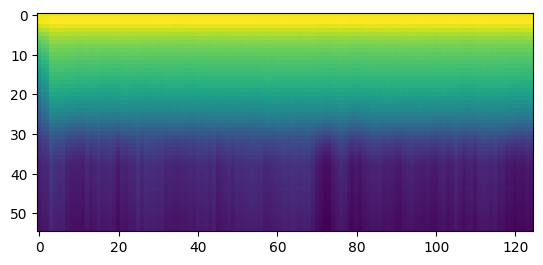

In [ ]:
# mat=spio.loadmat("/content/gdrive/MyDrive/2022-23/Honors Thesis/hudetz_stsps/_fft_stsp_sub_001.mat")
# data=mat["stsp"]
# plt.imshow(data)

PREPROCESSING FOR OLD DATA (of different lengths):

In [ ]:
#helper function: pad each image WIDTH so all are same input size 

def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desired width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2,0)
    aa = max(0,xx - a - h)
    b = max(0,(yy - w) // 2)
    bb = max(yy - b - w,0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [ ]:
#PADDING VERSION:
#import files and save in dataframe, adding labels and padding images properly

NUM_SUBJECTS=18
LARGEST_X_DIM=55
LARGEST_Y_DIM=178

#array initialized w/ 0s for image data (all x*2 STSPs)
all_data=np.zeros((NUM_SUBJECTS*2,LARGEST_X_DIM*LARGEST_Y_DIM))
#array initialized w/ 2s for label data (0 for wake, 1 for sleep)
all_labels=np.ones((NUM_SUBJECTS*2))*2 #initialize with twos

#iterate through each STSP
for i in range(1,1+NUM_SUBJECTS*2):
  mat=spio.loadmat(f"/content/gdrive/MyDrive/2022-23/Honors Thesis/_fft_stsp_sub_0{i}.mat")
  stsp = mat["stsp"]
  padded = padding(stsp,LARGEST_X_DIM,LARGEST_Y_DIM) #pad accordingly
  flat = padded.flatten() #remove structure for SVM input
  all_data[i-1]=flat

  #create labels dataframe
  if i % 2 == 0: # even=wakefulness state, add label [0]
    all_labels[i-1]=0
  else: # odd=sleep state, add label [1] 
    all_labels[i-1]=1

#reshape to be 4dim from 3dim
#all_data=np.reshape(all_data,(NUM_SUBJECTS*2,LARGEST_X_DIM,LARGEST_Y_DIM,1))

In [ ]:
#CROPPING VERSION
#import files and save in dataframe, adding labels and cropping images properly

NUM_SUBJECTS=18
LARGEST_X_DIM=55
LARGEST_Y_DIM=100

#array initialized w/ 0s for image data (all x*2 STSPs)
all_data=np.zeros((NUM_SUBJECTS*2,LARGEST_X_DIM*LARGEST_Y_DIM))
#array initialized w/ 2s for label data (0 for wake, 1 for sleep)
all_labels=np.ones((NUM_SUBJECTS*2))*2 #initialize with twos

#iterate through each STSP
for i in range(1,1+NUM_SUBJECTS*2):
  mat=spio.loadmat(f"/content/gdrive/MyDrive/2022-23/Honors Thesis/_fft_stsp_sub_0{i}.mat")
  stsp = mat["stsp"]
  cropped = stsp[:,:100]  #crop accordingly
  flat = cropped.flatten() #remove structure for SVM input
  all_data[i-1]=flat

  #create labels dataframe
  if i % 2 == 0: # even=wakefulness state, add label [0]
    all_labels[i-1]=0
  else: # odd=sleep state, add label [1] 
    all_labels[i-1]=1

#reshape to be 4dim from 3dim
#all_data=np.reshape(all_data,(NUM_SUBJECTS*2,LARGEST_X_DIM,LARGEST_Y_DIM,1))

In [ ]:
#DROP unusable subjects from data
DROP_sub = [7,8,9,10,13,14,17,18,19,20,21,22,27,28,31,32,33,34]
DROP_bad = #[8,10,18,19,21,22,27,28,31,32,33] #THESE SHOULD BE MOVED BACK ONE INDEX? 0-indexing (CHECK ORDER AGAIN, added in order of info.mat)

all_data=np.delete(all_data,DROP_bad,axis=0)
all_labels=np.delete(all_labels,DROP_bad,axis=0)

In [ ]:
print(all_data.shape,all_labels.shape)
all_data,all_labels

(25, 5500) (25,)


(array([[0.67190759, 0.68193608, 0.6879338 , ..., 0.03783506, 0.0382989 ,
         0.03682233],
        [0.6063963 , 0.63272848, 0.64782544, ..., 0.04960047, 0.04559763,
         0.04383665],
        [0.59186323, 0.62133627, 0.6388415 , ..., 0.05401315, 0.05075636,
         0.05209382],
        ...,
        [0.68571397, 0.69157559, 0.69574584, ..., 0.04433703, 0.04687393,
         0.04485019],
        [0.71279655, 0.71274347, 0.712335  , ..., 0.06417103, 0.06005193,
         0.05047246],
        [0.70896536, 0.7096057 , 0.71005425, ..., 0.05638925, 0.05560319,
         0.06107454]]),
 array([1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 0., 1., 0.]))

In [16]:
#split into training/validation and testing, with specified test_size split and ensuring both train/test have same amount of sleep/wake data
# TEST_SIZE=.3

# #train-test split from all_data
# x_train,x_test,y_train,y_test=train_test_split(all_data,all_labels,test_size=TEST_SIZE,stratify=all_labels)
# print(x_train.shape,x_test.shape)

#train-val split for train data
# x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=TEST_SIZE,#random_state=1234,stratify=y_train)
# print(x_train.shape,x_val.shape,y_train,y_val)
# print(x_train[2])

# #train-test split from all_data
# x_train,x_test,y_train,y_test=train_test_split(all_data,all_labels,test_size=TEST_SIZE,stratify=all_labels)
# print(x_train.shape,x_test.shape)

#train-test split from all_data AND all_test_data
x_train,x_test,y_train,y_test=all_data,all_test_data,all_labels,all_test_labels
print(x_train.shape,x_test.shape)

(25, 5500) (43, 5500)


In [ ]:
# #normalize data: Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network.
# x_train=np.array((x_train-np.min(x_train))/(np.max(x_train)-np.min(x_train)))
# x_test = np.array((x_test-np.min(x_test))/(np.max(x_test)-np.min(x_test)))
# x_train=x_train/np.std(x_train)
# x_test=x_test/np.std(x_test)
# x_train,x_test

(array([[2.78818138, 2.88949551, 2.95016211, ..., 0.23719518, 0.24429098,
         0.26486176],
        [2.64611978, 2.78102068, 2.8622488 , ..., 0.02937003, 0.02845375,
         0.03602738],
        [2.61062299, 2.75112602, 2.83647361, ..., 0.28220288, 0.23942408,
         0.21454541],
        ...,
        [2.75526428, 2.86454829, 2.92856624, ..., 0.08396691, 0.08945904,
         0.11008781],
        [2.75052539, 2.8602325 , 2.92615823, ..., 0.08204981, 0.0841783 ,
         0.07439286],
        [2.73769993, 2.8496485 , 2.91756301, ..., 0.05596052, 0.05105101,
         0.04448498]]),
 array([[2.80621872, 2.91704584, 2.9847274 , ..., 0.3401377 , 0.34027408,
         0.32828311],
        [2.88429866, 2.97705374, 3.02318394, ..., 0.28455018, 0.28691657,
         0.30988443],
        [2.73345033, 2.85255723, 2.92601502, ..., 0.13639164, 0.12850454,
         0.11983965],
        ...,
        [2.67275894, 2.81607799, 2.90209999, ..., 0.40400548, 0.38341882,
         0.39895562],
        [2.8

In [ ]:
#plt.imshow(mat["stsp"])

Let's take a look at our dataset. 

In [ ]:
train_labels=["wake","unconscious"]#,"recovery"]

In [ ]:
plt.figure(figsize=(10,10))

for i in range(20): #loop through grid, plot each image
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)

  plt.imshow(x_train[i])
  plt.xlabel(train_labels[int(y_train[i])]) #label w/ class names 
plt.show()


## Building a Model

MRMR (https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b) 

SVMS advantages (https://scikit-learn.org/stable/modules/svm.html):
- effective in high dimensional spaces
- effective where # of dimensions > number of samples


In [ ]:
#!pip install mrmr_selection 
from mrmr import mrmr_classif

selected_features=mrmr_classif(x_train,y_train,K=10)

### Leave One Out Implementation

In [36]:
#leave one data point out at a time

#SVM
svm_accuracy = []
svm_params = []

for i in range(len(all_data)):
  train_x = np.delete(all_data,i,axis=0)
  train_y = np.delete(all_labels,i)
  test_x = all_data[i]
  test_y = all_labels[i]

  param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','linear','poly']}
  svc=svm.SVC()
  model=GridSearchCV(svc,param_grid) #can print cv_results_ attribute of gridsearch model if desired!
  model.fit(train_x,train_y)
  pred = model.predict(test_x.reshape(1,-1))
  if pred == test_y:
    val=1
  else:
    val=0
  
  svm_accuracy.append(val)
  svm_params.append(model.best_params_)

print("SVM: ", mean(svm_accuracy))

#DT
dt_accuracy = []
dt_params = []

for i in range(len(all_data)):
  train_x = np.delete(all_data,i,axis=0)
  train_y = np.delete(all_labels,i)
  test_x = all_data[i]
  test_y = all_labels[i]

  param_grid={'criterion':['gini','entropy'],'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12]}
  tree=DecisionTreeClassifier()
  model=GridSearchCV(tree,param_grid) #can print cv_results_ attribute of gridsearch model if desired!
  model.fit(train_x,train_y)
  pred = model.predict(test_x.reshape(1,-1))
  if pred == test_y:
    val=1
  else:
    val=0
  
  dt_accuracy.append(val)
  dt_params.append(model.best_params_)

print("DT: ", mean(dt_accuracy))

#KNN
knn_accuracy = []
knn_params = []

for i in range(len(all_data)):
  train_x = np.delete(all_data,i,axis=0)
  train_y = np.delete(all_labels,i)
  test_x = all_data[i]
  test_y = all_labels[i]

  param_grid={'n_neighbors':[1,2,3,4,5,6,7,8,9],'weights':['uniform','distance'],'metric':['euclidean','manhattan','minkowski']}
  knn=KNeighborsClassifier()
  model=GridSearchCV(knn,param_grid) #can print cv_results_ attribute of gridsearch model if desired!
  model.fit(train_x,train_y)
  pred = model.predict(test_x.reshape(1,-1))
  if pred == test_y:
    val=1
  else:
    val=0
  
  knn_accuracy.append(val)
  knn_params.append(model.best_params_)


print("KNN: ", mean(knn_accuracy))

#Gaussian - no hyperparams
nbc_accuracy = []
#nbc_params = []

for i in range(len(all_data)):
  train_x = np.delete(all_data,i,axis=0)
  train_y = np.delete(all_labels,i)
  test_x = all_data[i]
  test_y = all_labels[i]

  #param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','linear','poly']}
  nbc=GaussianNB()
  #model=GridSearchCV(nbc,param_grid) #can print cv_results_ attribute of gridsearch model if desired!
  nbc.fit(train_x,train_y)
  pred = model.predict(test_x.reshape(1,-1))
  if pred == test_y:
    val=1
  else:
    val=0
  
  nbc_accuracy.append(val)
  #nbc_params.append(model.best_params_)

print("NBC: ", mean(nbc_accuracy))

#RF
rf_accuracy = []
rf_params = []

for i in range(len(all_data)):
  train_x = np.delete(all_data,i,axis=0)
  train_y = np.delete(all_labels,i)
  test_x = all_data[i]
  test_y = all_labels[i]

  n_estimators = [90,100,115,130]
  # Number of features to consider at every split
  max_features = ['auto', 'log2']
  # Maximum number of levels in tree
  max_depth = [2, 10, 15, 20]
  # Minimum number of samples required to split a node
  min_samples_split = [2, 5, 10]
  # Minimum number of samples required at each leaf node
  min_samples_leaf = [1, 2, 4]
  # Method of selecting samples for training each tree
  criterion = ['gini','entropy']
  # Create the random grid
  param_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'criterion': criterion}
  
  rf=RandomForestClassifier()
  model=RandomizedSearchCV(rf,param_grid) #can print cv_results_ attribute of gridsearch model if desired!
  model.fit(train_x,train_y)
  pred = model.predict(test_x.reshape(1,-1))
  if pred == test_y:
    val=1
  else:
    val=0
  
  rf_accuracy.append(val)
  rf_params.append(model.best_params_)

print("RF: ", mean(rf_accuracy))

SVM:  0.5
DT:  0.5909090909090909


KeyboardInterrupt: ignored

In [ ]:
print("SVM: ", mean(svm_accuracy))
print("DT: ", mean(dt_accuracy))
print("KNN: ", mean(knn_accuracy))
print("NBC: ", mean(nbc_accuracy))
print("RF: ", mean(rf_accuracy))

SVM:  0.76
DT:  0.68
KNN:  0.44
NBC:  0.64
RF:  0.64


In [ ]:
print(svm_params)

[{'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 100, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}, {'C': 10, 'g

In [37]:
from sklearn import svm 
#cross validates across SVM model parameters to get best one


param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','linear','poly']}

svc=svm.SVC()
model=GridSearchCV(svc,param_grid)

model.fit(x_train,y_train)
model.best_params_


{'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}

In [38]:
from sklearn import svm 

SVC=svm.SVC(C=10,gamma=.0001,kernel='linear')
SVC.fit(x_train,y_train)

y_pred=SVC.predict(x_test)
print(accuracy_score(y_pred,y_test))
print(confusion_matrix(y_pred,y_test))
classification_report(y_pred,y_test)

0.5348837209302325
[[11  4]
 [16 12]]


'              precision    recall  f1-score   support\n\n         0.0       0.41      0.73      0.52        15\n         1.0       0.75      0.43      0.55        28\n\n    accuracy                           0.53        43\n   macro avg       0.58      0.58      0.53        43\nweighted avg       0.63      0.53      0.54        43\n'

In [ ]:
#only works for linear SVC
#SVC.coef_ 

In [39]:
#cross validate data to determine best max_depth parameter
from sklearn import tree
# N=30 #largest max_depth
# training_scores=np.zeros(N)
# testing_scores=np.zeros(N)
# depths=np.arange(1,31)


# for d in range(1, 30):
#     T = tree.DecisionTreeClassifier(max_depth = d)
#     T.fit(x_train, y_train)
#     training_scores[d-1]=T.score(x_train,y_train)
#     testing_scores[d-1]=T.score(x_test,y_test)
# print(training_scores,testing_scores)
    
    
# fig, ax = plt.subplots(1, figsize = (10, 7))
    
# ax.scatter(depths,training_scores,color="black",label="training")
# ax.scatter(depths,testing_scores,color="firebrick",label="testing")    
# ax.set(xlabel = "Complexity (depth)", ylabel = "Performance (score)",ylim=(.73,1))
# ax.legend()

T = tree.DecisionTreeClassifier()

max_depth = range(1,15)
# Create the random grid
random_grid = {'max_depth': max_depth}
grid_search=GridSearchCV(T,param_grid=random_grid)
grid_search.fit(x_train,y_train)
grid_search.best_params_

{'max_depth': 3}

In [40]:
from sklearn import tree

T=tree.DecisionTreeClassifier(max_depth=3)
T.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=3)

In [41]:
y_pred=T.predict(x_test)
accuracy_score(y_pred,y_test)

0.627906976744186

In [42]:
from sklearn.neighbors import KNeighborsClassifier

#cross validate data to determine best max_depth parameter

# N=10 #largest max_depth
# training_scores=np.zeros(N)
# testing_scores=np.zeros(N)
# neighbors=np.arange(1,11)

# for d in range(1, 11):
#     knn = KNeighborsClassifier(n_neighbors = d)
#     knn.fit(x_train, y_train)
#     y_pred=knn.predict(x_test)
#     training_scores[d-1]=accuracy_score(y_pred,y_test)
#     testing_scores[d-1]=accuracy_score(y_pred,y_test)
    
# print(training_scores,testing_scores)
# fig, ax = plt.subplots(1, figsize = (10, 7))
    
# ax.scatter(neighbors,training_scores,color="black",label="training")
# ax.scatter(neighbors,testing_scores,color="firebrick",label="testing")    
# ax.set(xlabel = "Complexity (depth)", ylabel = "Performance (score)",ylim=(0,1))
# ax.legend()

KNN = KNeighborsClassifier()

n_neighbors = range(1,15)
# Create the random grid
random_grid = {'n_neighbors': n_neighbors}
grid_search=GridSearchCV(KNN,param_grid=random_grid)
grid_search.fit(x_train,y_train)
grid_search.best_params_

{'n_neighbors': 7}

In [43]:
#choose k=7
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train,y_train)
y_predict=knn.predict(x_test)
accuracy_score(y_predict,y_test)

0.5348837209302325

In [44]:
from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()
GNB.fit(x_train, y_train)
y_pred=GNB.predict(x_test)
accuracy_score(y_pred,y_test)

0.37209302325581395

In [45]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [90,100,115,130]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [2, 10, 15, 20]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
criterion = ['gini','entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion}


RF = RandomForestClassifier()
grid_search=RandomizedSearchCV(RF,random_grid)
grid_search.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 10, 15, 20],
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [90, 100, 115, 130]})

In [46]:
grid_search.best_params_

{'n_estimators': 115,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 2,
 'criterion': 'gini'}

In [47]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(criterion='gini',
                          max_depth=2,
                          max_features='auto',
                          min_samples_leaf=4,
                          min_samples_split=2,
                          n_estimators=115)
RF.fit(x_train,y_train)
y_pred=RF.predict(x_test)
print(classification_report(y_pred,y_test))
print(confusion_matrix(y_pred,y_test))
accuracy_score(y_pred,y_test)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


              precision    recall  f1-score   support

         0.0       0.85      0.70      0.77        33
         1.0       0.38      0.60      0.46        10

    accuracy                           0.67        43
   macro avg       0.61      0.65      0.61        43
weighted avg       0.74      0.67      0.70        43

[[23 10]
 [ 4  6]]


0.6744186046511628

In [ ]:
model.summary() #limit # of trainable parameters (conv2D provides limitations,takes less time than Dense layers would)

NameError: ignored

Let's see how our model does over epochs! 

In [ ]:
plt.plot(history.history["accuracy"],label='training')
plt.plot(history.history["val_accuracy"],label='validation')
plt.legend()

## Extracting Predictions

Let's see how our model did on the test data: 

In [ ]:
y_pred=model.predict(x_test)
y_pred

array([0., 1., 1., 1., 0., 1., 0., 0.])

We'll plot these predicted labels along side the (true labels). 

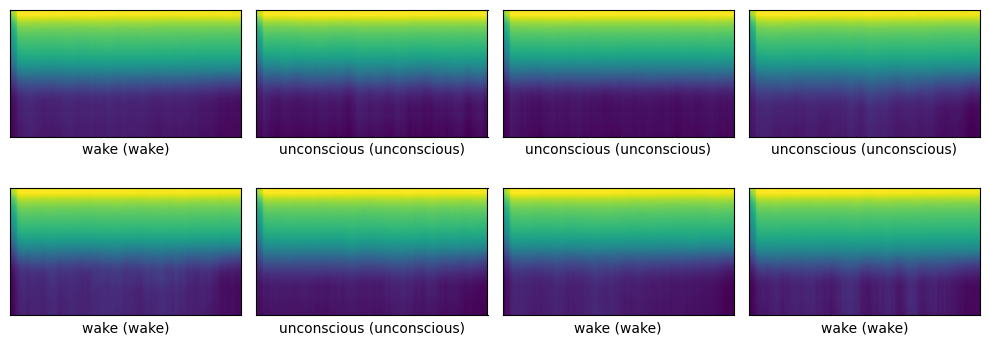

In [ ]:
plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.reshape(x_test[i],(55,100)))
    num=int(y_test[i])
    plt.xlabel(train_labels[int(y_pred[i])] + f" ({train_labels[num]})")
plt.tight_layout()
plt.show()

# Generating Group Means





In [ ]:
wake=[]
unconscious=[]
recovery=[]

for i, label in enumerate(all_labels):
  if label==0:
    wake.append(all_data[i])
  elif label==1:
    unconscious.append(all_data[i])
  elif label==2:
    recovery.append(all_data[i]) # if exists in data breakdown

wake_mean = np.mean(np.array(wake),axis=0)
unconscious_mean = np.mean(np.array(unconscious),axis=0)
if len(recovery) != 0:
  recovery_mean = np.mean(np.array(recovery),axis=0)

In [ ]:
wake

[array([0.6063963 , 0.63272848, 0.64782544, ..., 0.04960047, 0.04559763,
        0.04383665]),
 array([0.63849451, 0.65727979, 0.66666336, ..., 0.04006836, 0.03433779,
        0.03383322]),
 array([0.67866132, 0.68726446, 0.69125865, ..., 0.03261001, 0.0324511 ,
        0.0313118 ]),
 array([0.61874907, 0.64221095, 0.65630977, ..., 0.04807099, 0.04852619,
        0.04643348]),
 array([0.59960685, 0.62718563, 0.64373518, ..., 0.05750966, 0.05814729,
        0.05573593]),
 array([0.62637483, 0.64777175, 0.66094452, ..., 0.05098403, 0.05059785,
        0.04907268]),
 array([0.60541903, 0.63221419, 0.6485159 , ..., 0.03844944, 0.04162384,
        0.03518492]),
 array([0.61860406, 0.64119264, 0.65534221, ..., 0.04221289, 0.04414576,
        0.04279933]),
 array([0.61976253, 0.64313392, 0.65682475, ..., 0.04848098, 0.04965552,
        0.05406717]),
 array([0.623037  , 0.64550112, 0.65885403, ..., 0.05639288, 0.05631841,
        0.05719039]),
 array([0.71206307, 0.71202861, 0.71238437, ..., 0

In [ ]:
el1 = [item[0] for item in wake]
el1

# el2=[item[15] for item in unconscious]
# el2

# variance(el2)/variance(el1)

[0.6063962958803446,
 0.6384945108633464,
 0.6786613157831736,
 0.6187490722784957,
 0.5996068503691059,
 0.6263748281838559,
 0.605419027873371,
 0.6186040564376925,
 0.6197625277520201,
 0.6230370049131748,
 0.7120630717648851,
 0.7109249008008323,
 0.6857139673717934,
 0.708965355959442]

In [ ]:
stats.ttest_ind(el1,el2)

Ttest_indResult(statistic=0.29743815298309956, pvalue=0.7688019629093292)

In [ ]:
ttest_ind_results = []

for i in (range(len(all_data[0]))):
  wake_i = [item[i] for item in wake]
  unconscious_i = [item[i] for item in unconscious]

  #T TEST ASSUMPTIONS: independent samples, random sampling, normal distribution -> mann whitney u test? 
  #independent or dependent?
  #t.test - welsh's or pooled (check variance of wake/unconscious), paired or no, FDR correction
  #equal var True (Student's), independent?, FDR correction
  #ASSESS SIGNIFICANCE - compare t tests? across all 1500 cols? (check robyn paper, IEEE paper) -> return sig cols? 
  #(is there a diff between cols)

  ttest_ind_results.append(stats.ttest_ind(wake_i,unconscious_i))

#print(sig_cols)


In [ ]:
pvals=[]

for result in ttest_ind_results:
  pvals.append(result[1])

In [ ]:
pvals

In [ ]:
from statsmodels.stats.multitest import fdrcorrection
adjustedps = fdrcorrection(pvals,alpha=0.1)

In [ ]:
adjustedps

(array([False, False, False, ..., False, False, False]),
 array([0.99992694, 0.99992694, 0.99992694, ..., 0.99992694, 0.99992694,
        0.99992694]))

In [ ]:
for i,val in enumerate(adjustedps[0]):
  if val==True:
    print(i)

205
206
304
305
306
307
404
405
406
407
504
505
506
507
604
605
606
706


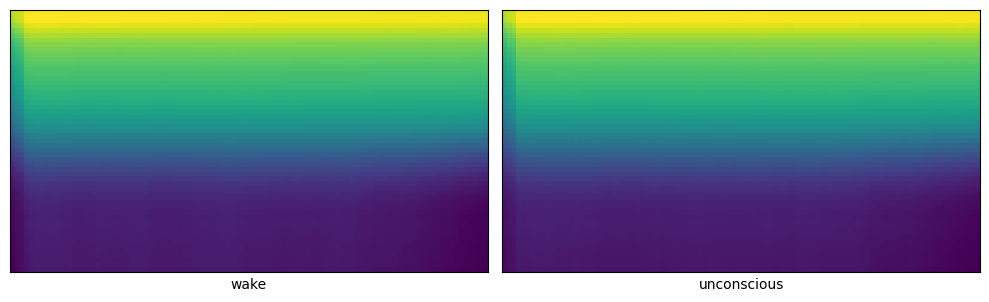

In [ ]:
#visualize group mean STSPs

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(np.reshape(wake_mean,(55,100)))
plt.xlabel("wake")

plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(np.reshape(unconscious_mean,(55,100)))
plt.xlabel("unconscious")

plt.tight_layout()
plt.show()

# Visualizing Learned Features 

It's possible to define a separate model that allows us to study the features learned by the model. These are often called *activations*. We create this model by simply asserting that the model outputs are equal to the outputs of the first convolutional layer. For this we use the `models.Model` class rather than the `models.Sequential` class, which is more convenient but less flexible. 

It's possible to look at the activations at different levels of the model. Generally speaking, it is expected that the activations become more abstract as one goes higher up the model structure. 

In [ ]:
#only looking at outputs of first layer

activation_model=models.Model(inputs=SVC.input,outputs=SVC.layers[0].output)

AttributeError: ignored

Now we can compute the activations

In [ ]:
activations=activation_model.predict(train_images[0:10])

And visualize them! 

In [ ]:
k = 7

color_im = x_train[k:(k+1)]
convd = conv(color_im).numpy()

fig, axarr = plt.subplots(3, 3, figsize = (8, 6))

axarr[0, 0].imshow(color_im[0])
axarr[0,0].axis("off")
axarr[0,0].set(title = "Original")

i = 0
for ax in axarr.flatten()[1:]:
    ax.imshow(activations[k,:,:,i], cmap = "gray")
    i += 1
    ax.axis("off")
    ax.set(title = "Feature " + str(i))
    
plt.tight_layout()

Somewhat romantically, these activations might be interpreted as "how the algorithm looks at" the resulting image. That said, one must be careful of over-interpretation. Still, it looks like some of the features correspond to edge detection (like we saw above), while others correspond to highlighting different patches of colors, enabling, for example, separation of the foreground object from the background. 